In [1]:
import numpy as np
from quantum_code import *
import matplotlib.pyplot as plt
from classical_code import *
import galois
from ldpc import BpDecoder, BpOsdDecoder
from ldpc.bplsd_decoder import BpLsdDecoder
from numpy.linalg import matrix_power, matrix_rank
from tqdm import tqdm

In [133]:
qubit_error_rate = 0.01
meas_error_rate = 0.01

qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_100_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_400_16.qcode")
qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_900_36.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_900_36_2.qcode")

# qcode = read_qcode("../codes/qcodes/BB_72_12/BB_72_12.qcode")


Hx, Hz, Lx, Lz, mapping = qcode.to_numpy()
H = Hx
L = Lx

qec_aug_dec = BpDecoder(
    np.hstack([H, np.eye(H.shape[0], dtype=int)]),
    channel_probs=[qubit_error_rate]*H.shape[1] + [meas_error_rate]*H.shape[0],
    bp_method="ps",
    max_iter=30,
    schedule="serial"
    # osd_method="osd0",
    # osd_order=4 #the osd search depth
)

qec_dec = BpLsdDecoder(
    H,
    error_rate=qubit_error_rate,
    bp_method="ps",
    max_iter=30,
    schedule="serial",
    osd_method="lsd_cs",
    osd_order=4 #the osd search depth
)

In [134]:
num_iters = 1000
num_rounds = 10
successes = 0

for i in tqdm(range(num_iters)):
    success = 1
    curr_qubit_error = np.zeros(Hx.shape[1], dtype=int)

    for j in range(num_rounds):
        new_qubit_error = np.random.choice([0, 1], size=H.shape[1], p=[1-qubit_error_rate, qubit_error_rate])
        new_synd_error = np.random.choice([0, 1], size=H.shape[0], p=[1-meas_error_rate, meas_error_rate])
        curr_qubit_error ^= new_qubit_error

        curr_synd = ((H @ curr_qubit_error) % 2) ^ new_synd_error
        curr_qubit_error ^= qec_aug_dec.decode(curr_synd)[:H.shape[1]]

    curr_synd = ((H @ curr_qubit_error) % 2)
    curr_qubit_error ^= qec_dec.decode(curr_synd)
    obs = (L @ curr_qubit_error) % 2

    if np.any(obs):
        success = 0

    successes += success

print(successes/num_iters)
print()

100%|██████████| 1000/1000 [00:40<00:00, 24.92it/s]

0.946



In [79]:
from math import comb

def prob(n, p):
    p_sum = 0
    for k in range(n//2):
        p_sum += comb(n, 2*k+1) * p**(2*k+1) * (1-p)**(n-(2*k+1))
    return p_sum

print(prob(16, 1e-3))
print(prob(4, 1e-3))
print(prob(8, 1e-3))

0.015762225509632473
0.003988015992
0.007944223440895105


In [77]:
deltaV = 3
deltaC = 7

def get_scaling(n, p):
    num_non_adaptive_CNOTs = []
    num_adaptive_CNOTs = []
    iss = []

    for i in range(100, 10000):
        if (i % (n-2) == 0):
            iss.append(i)
            num_non_adaptive_CNOTs.append(i * deltaV)

            expected_CNOTs = (i // (n-2)) * prob(n, p) * (n * deltaV) * 2 * deltaC
            expected_CNOTs += (i // (n-2)) * n
            num_adaptive_CNOTs.append(expected_CNOTs)

    return iss, num_non_adaptive_CNOTs, num_adaptive_CNOTs

p = 0.001
x1, nna1, na1 = get_scaling(4, p)
x2, _, na2 = get_scaling(8, p)
x3, _, na3 = get_scaling(12, p)


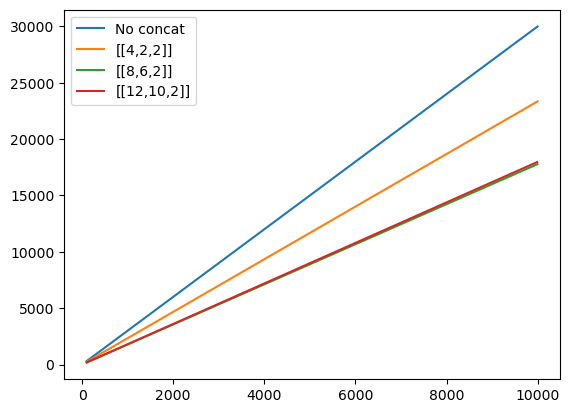

In [78]:
plt.plot(x1, nna1, label="No concat")
plt.plot(x1, na1, label="[[4,2,2]]")
plt.plot(x2, na2, label="[[8,6,2]]")
plt.plot(x3, na3, label="[[12,10,2]]")

plt.legend()


In [136]:
import stim

noise = 0.001
circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=1,
    distance=4,
    after_clifford_depolarization=noise,
    after_reset_flip_probability=noise,
    before_measure_flip_probability=noise,
    before_round_data_depolarization=noise,
)
circuit

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(6, 0) 6
    QUBIT_COORDS(7, 1) 7
    QUBIT_COORDS(1, 3) 10
    QUBIT_COORDS(2, 2) 11
    QUBIT_COORDS(3, 3) 12
    QUBIT_COORDS(4, 2) 13
    QUBIT_COORDS(5, 3) 14
    QUBIT_COORDS(6, 2) 15
    QUBIT_COORDS(7, 3) 16
    QUBIT_COORDS(0, 4) 18
    QUBIT_COORDS(1, 5) 19
    QUBIT_COORDS(2, 4) 20
    QUBIT_COORDS(3, 5) 21
    QUBIT_COORDS(4, 4) 22
    QUBIT_COORDS(5, 5) 23
    QUBIT_COORDS(6, 4) 24
    QUBIT_COORDS(7, 5) 25
    QUBIT_COORDS(8, 4) 26
    QUBIT_COORDS(1, 7) 28
    QUBIT_COORDS(2, 6) 29
    QUBIT_COORDS(3, 7) 30
    QUBIT_COORDS(4, 6) 31
    QUBIT_COORDS(5, 7) 32
    QUBIT_COORDS(6, 6) 33
    QUBIT_COORDS(7, 7) 34
    QUBIT_COORDS(2, 8) 38
    QUBIT_COORDS(6, 8) 42
    R 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
    X_ERROR(0.001) 1 3 5 7 10 12 14 16 19 21 23 25 28 30 32 34
    R 2 6 11 13 15 18 20 22 24 26 29 31 33 38 42
    X_ERROR(0.001) 2 